In [46]:
import glob

files = glob.glob("MICCAI_BraTS2020_TrainingData//"+"**//*flair.nii",recursive=True)

In [47]:
len(files)

108

In [48]:
files[1]

'MICCAI_BraTS2020_TrainingData\\BraTS20_Training_078\\BraTS20_Training_078_flair.nii'

In [49]:
import skimage.io as io

In [50]:
örnek =files[1]

`simpleitk` tıbbı, ct, mr gibi görüntüleri incelemek için özel olarak hazırlanmış bir plugin

In [51]:
img = io.imread(örnek,plugin="simpleitk")

In [52]:
img.shape

(155, 240, 240)

In [53]:
img.dtype

dtype('int16')

In [54]:
import matplotlib.pyplot as plt

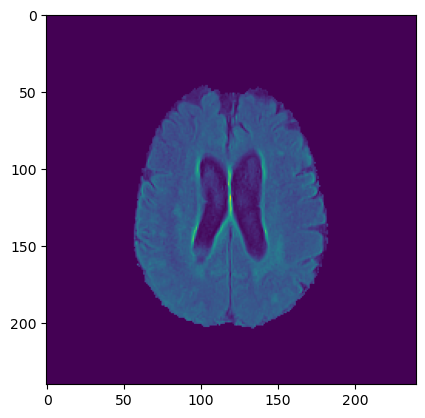

In [55]:
plt.imshow(img[90,:,:])

Text(0.5, 1.0, 'coronal kesit')

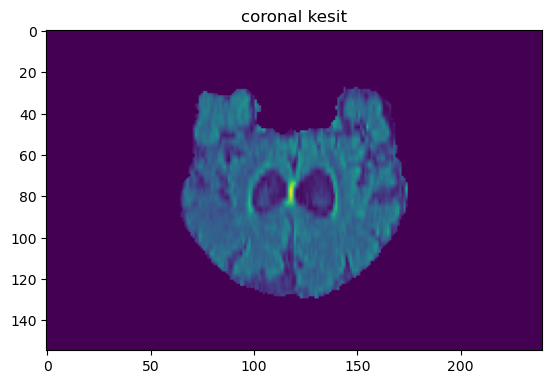

In [56]:
plt.imshow(img[:,90,:])
plt.title("coronal kesit")

Text(0.5, 1.0, 'segittal kesit')

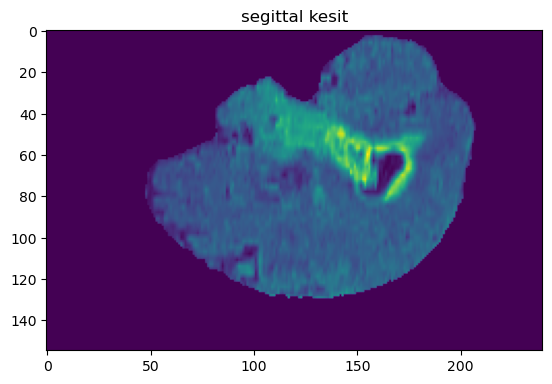

In [57]:
plt.imshow(img[:,:,90])
plt.title("segittal kesit")

In [59]:
img_seg =io.imread("MICCAI_BraTS2020_TrainingData\\BraTS20_Training_001\\BraTS20_Training_001_seg.nii",plugin="simpleitk")

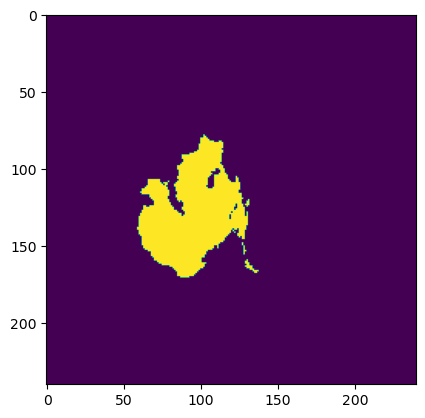

In [60]:
plt.imshow(img_seg[90,:,:])

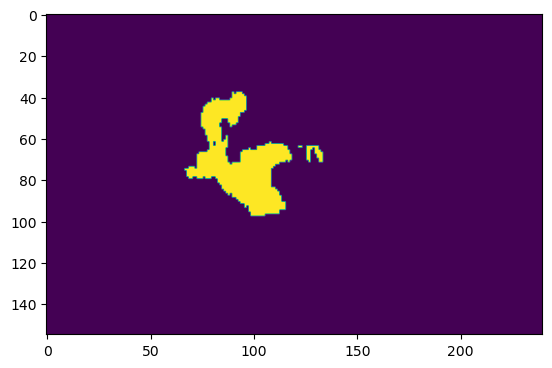

In [61]:
plt.imshow(img_seg[:,90,:])

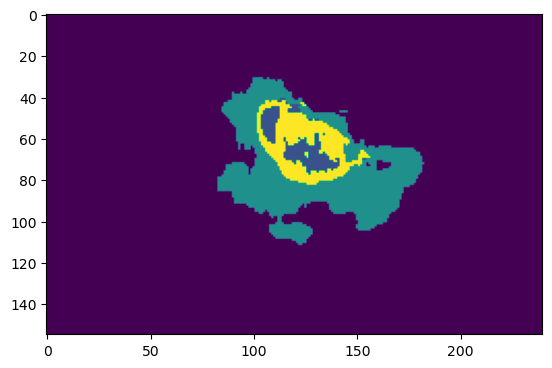

In [62]:
plt.imshow(img_seg[:,:,90])

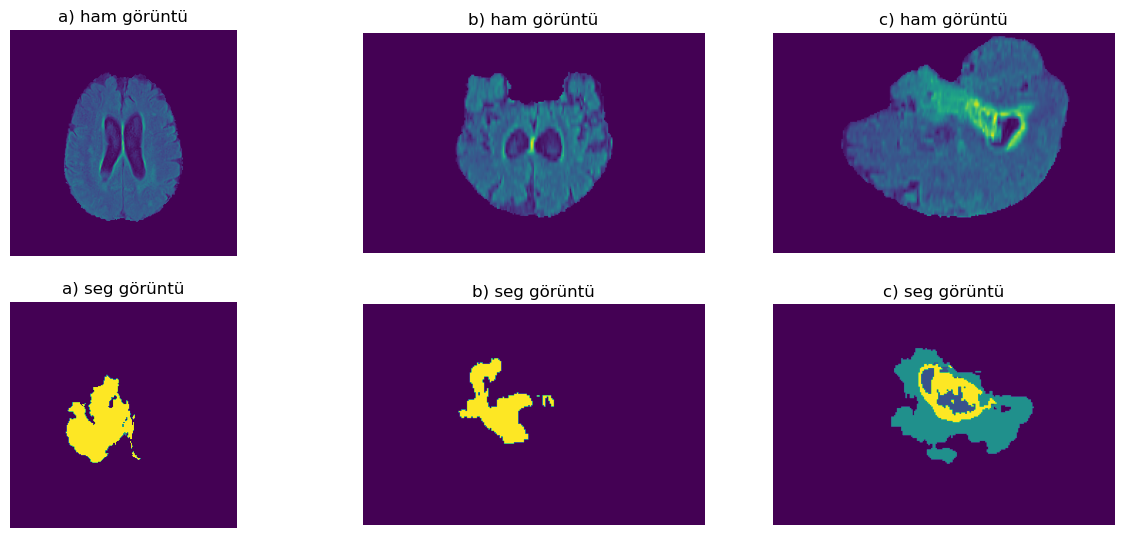

In [63]:
plt.figure(figsize=(15,10))

plt.subplot(3,3,3)
plt.title('c) ham görüntü')
plt.axis('off')
plt.imshow(img[:,:,90])

plt.subplot(3,3,2)
plt.title('b) ham görüntü')
plt.axis('off')
plt.imshow(img[:,90,:])

plt.subplot(3,3,1)
plt.title('a) ham görüntü')
plt.axis('off')
plt.imshow(img[90,:,:])

plt.subplot(3,3,6)
plt.title('c) seg görüntü')
plt.axis('off')
plt.imshow(img_seg[:,:,90])

plt.subplot(3,3,5)
plt.title('b) seg görüntü')
plt.axis('off')
plt.imshow(img_seg[:,90,:])

plt.subplot(3,3,4)
plt.title('a) seg görüntü')
plt.axis('off')
plt.imshow(img_seg[90,:,:])

In [64]:
import numpy as np
import random as r
import gc; gc.enable() # memory is tight

def train_array(path,end):
    files = glob.glob(path+end,recursive=True) # görüntülerin bulunduğu konumu glob modülü ile listeliyoruz
    img_liste = []
    r.seed(9)
    r.shuffle(files)
    for file in files[70:130] :
        img = io.imread(file,plugin='simpleitk') # görüntüleri okuyoruz
        img = (img-img.mean())/img.std() # standartize ediyoruz
        img.astype('float32')
        
        # burada bazı görüntüler işimize yaramadığı için belli aralıkdaki görüntüleri aldık
        for slice in range(80,110):
            img_s = img[slice,:,:] # burada verimiz iki boyuta düştü
            img_s = np.expand_dims(img_s,axis=0)# Unet modeline üç boyutlu görüntü sokmamız gerektiğinden 
                                                # boyutunu tekrar artırıyoruz
            img_liste.append(img_s)
    return np.array(img_liste,np.float32)

In [65]:
a = img[61,:,:]
a.shape

(240, 240)

In [66]:
img.shape

(155, 240, 240)

In [67]:
örnek_a =np.expand_dims(a,axis=0)
örnek_a.shape

(1, 240, 240)

In [68]:
path="MICCAI_BraTS2020_TrainingData//"
end="**//*flair.nii"

In [69]:
train = train_array(path,end)

In [70]:
train.shape

(1140, 1, 240, 240)

In [71]:
train_re =train[0].reshape(240,240)
train_re.shape

(240, 240)

In [72]:
train[0].shape

(1, 240, 240)

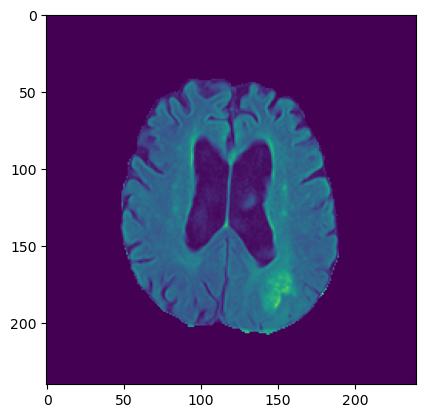

In [73]:
plt.imshow(train[100].reshape(240,240))

# 1. Nekroz (Non-enhancing Tumor)
# 2. Ödem ( Edema ) 
# 4. Genişleyen tümor ( Enhancing Tumor )

In [74]:
img_seg.shape

(155, 240, 240)

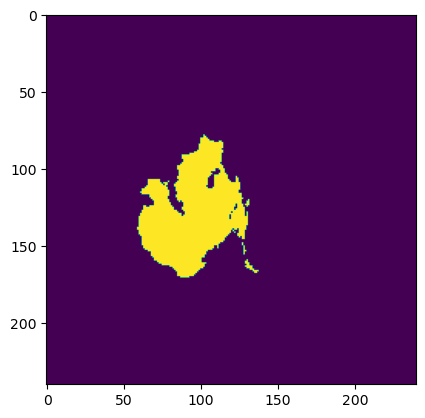

In [75]:
plt.imshow(img_seg[90,:,:])

In [76]:
seg_tam = img_seg.copy()

Text(0.5, 1.0, 'tam segmentasyon')

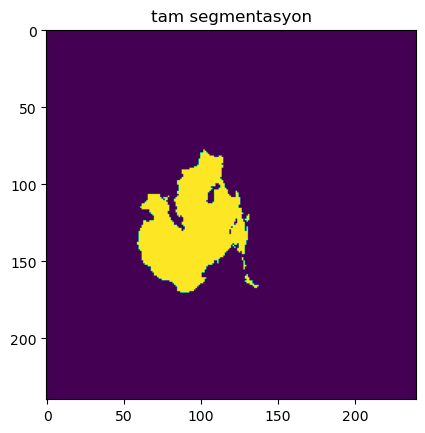

In [77]:
seg_tam[seg_tam != 0] = 1
plt.imshow(seg_tam[90,:,:])
plt.title('tam segmentasyon')

Text(0.5, 1.0, 'nekroz segmentasyon')

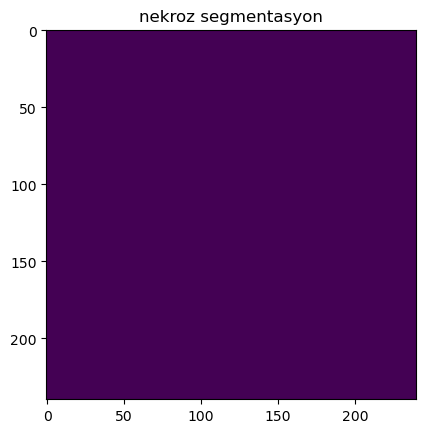

In [78]:
seg_nekroz = img_seg.copy()
seg_nekroz[seg_nekroz != 1] = 0
plt.imshow(seg_nekroz[90,:,:])
plt.title('nekroz segmentasyon')

Text(0.5, 1.0, 'ödem segmentasyon')

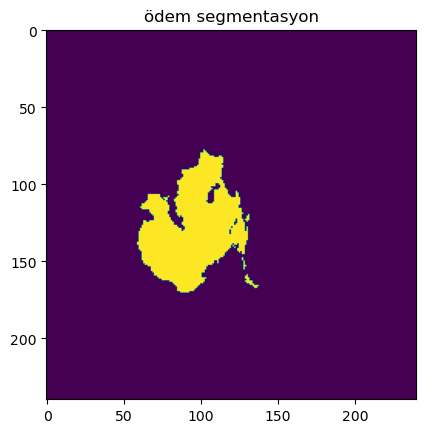

In [79]:
seg_ödem = img_seg.copy()
seg_ödem[seg_ödem == 1] = 0
seg_ödem[seg_ödem == 4] = 0
seg_ödem[seg_ödem != 0] = 1
plt.imshow(seg_ödem[90,:,:])
plt.title('ödem segmentasyon')

In [80]:
import numpy as np
import random as r
import gc; gc.enable() # memory is tight

def seg_array(path,end,label):
    files = glob.glob(path+end,recursive=True) # görüntülerin bulunduğu konumu glob modülü ile listeliyoruz
    img_liste = []
    r.seed(9)
    r.shuffle(files)
    for file in files[70:130] :
        img = io.imread(file,plugin='simpleitk') # görüntüleri okuyoruz
        
        if label == 1:
            img[img != 0] = 1 # Tam tümör
        if label == 2:
            img[img != 1] = 0 # Nekroz
        if label == 3:
            img[img == 2] = 0 # Ödemsiz tümör
            img[img != 0] = 1 
        if label == 4:
            img[img != 4] = 0 # Genişleyen tümör
            img[img == 4] = 1 
            
        img.astype('float32')
        
    
        # burada bazı görüntüler işimize yaramadığı için belli aralıkdaki görüntüleri aldık
        for slice in range(80,110):
            img_s = img[slice,:,:] # burada verimiz iki boyuta düştü
            img_s = np.expand_dims(img_s,axis=0)# Unet modeline üç boyutlu görüntü sokmamız gerektiğinden 
                                                # boyutunu tekrar artırıyoruz
            img_liste.append(img_s)
    
    return np.array(img_liste,np.float32)

In [81]:
path="MICCAI_BraTS2020_TrainingData//"
end="**//*seg.nii"

In [82]:
seg_tam = seg_array(path,end,1)
seg_nekroz = seg_array(path,end,2)
seg_ödemsiz = seg_array(path,end,3)
seg_geniş = seg_array(path,end,4)
seg_orj = seg_array(path,end,0)

Text(0.5, 1.0, 'ham görüntü')

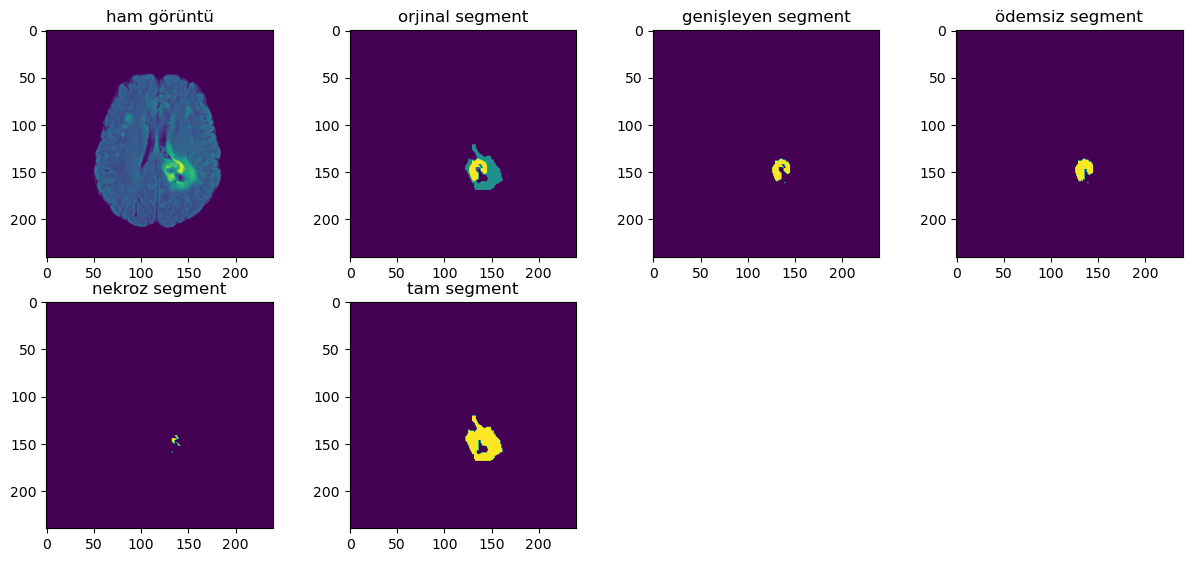

In [83]:
x=400

plt.figure(figsize=(15,10))

plt.subplot(3,4,6)
plt.imshow(seg_tam[x].reshape(240,240))
plt.title("tam segment")

plt.subplot(3,4,5)
plt.imshow(seg_nekroz[x].reshape(240,240))
plt.title("nekroz segment")

plt.subplot(3,4,4)
plt.imshow(seg_ödemsiz[x].reshape(240,240))
plt.title("ödemsiz segment")

plt.subplot(3,4,3)
plt.imshow(seg_geniş[x].reshape(240,240))
plt.title("genişleyen segment")

plt.subplot(3,4,2)
plt.imshow(seg_orj[x].reshape(240,240))
plt.title("orjinal segment")

plt.subplot(3,4,1)
plt.imshow(train[x].reshape(240,240))
plt.title("ham görüntü")

In [84]:
seg_tam.shape

(1140, 1, 240, 240)

In [85]:
train.shape

(1140, 1, 240, 240)

# Modeli Oluşturma ve Eğitme

In [89]:
#t2- flair göruntulere tumörun tam haline uygulacağız.
flair = train_array("MICCAI_BraTS2020_TrainingData//","**//*flair.nii") #flair göruntulerine
t2 = train_array("MICCAI_BraTS2020_TrainingData//","**//*t2.nii") #t2 göruntulerine
seg= seg_array("MICCAI_BraTS2020_TrainingData//","**//*seg.nii",1)

In [90]:
flair.shape, t2.shape ,seg.shape

((1140, 1, 240, 240), (1140, 1, 240, 240), (1140, 1, 240, 240))

flair görüntülerin de tümorün merkezi daha iyi görünürken , t2 görüntülerinde ödem daha belirgin görünüyor bu yüzden bu iki görüntüyü birleştrip eğitime sokacağız.

In [91]:
x_train = np.concatenate((flair,t2),axis=1)

In [92]:
x_train.shape

(1140, 2, 240, 240)

# Model

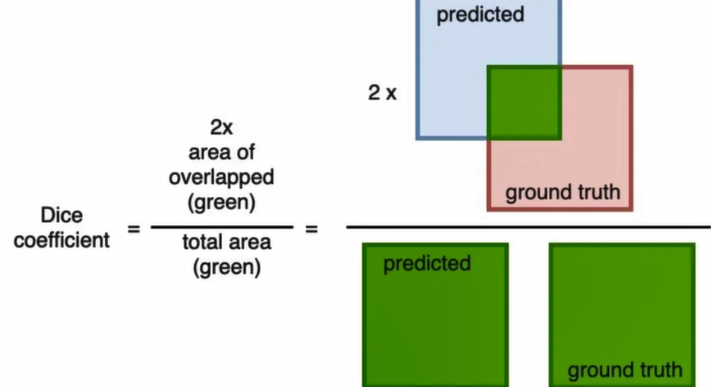

In [1]:
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.layers import Input, UpSampling2D,BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import tensorflow as tf

K.set_image_data_format('channels_first')


def dice_coef(y_true, y_pred):
    smooth = 0.005 
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)
    
def unet_model():
    
    inputs = Input((2, 240 , 240))
    
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same') (inputs)
    batch1 = BatchNormalization(axis=1)(conv1)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same') (batch1)
    batch1 = BatchNormalization(axis=1)(conv1)
    pool1 = MaxPooling2D((2, 2)) (batch1)
    
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same') (pool1)
    batch2 = BatchNormalization(axis=1)(conv2)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same') (batch2)
    batch2 = BatchNormalization(axis=1)(conv2)
    pool2 = MaxPooling2D((2, 2)) (batch2)
    
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same') (pool2)
    batch3 = BatchNormalization(axis=1)(conv3)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same') (batch3)
    batch3 = BatchNormalization(axis=1)(conv3)
    pool3 = MaxPooling2D((2, 2)) (batch3)
    
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same') (pool3)
    batch4 = BatchNormalization(axis=1)(conv4)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same') (batch4)
    batch4 = BatchNormalization(axis=1)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2)) (batch4)
    
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same') (pool4)
    batch5 = BatchNormalization(axis=1)(conv5)
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same') (batch5)
    batch5 = BatchNormalization(axis=1)(conv5)
    
    up6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same') (batch5)
    up6 = concatenate([up6, conv4], axis=1)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same') (up6)
    batch6 = BatchNormalization(axis=1)(conv6)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same') (batch6)
    batch6 = BatchNormalization(axis=1)(conv6)
    
    up7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same') (batch6)
    up7 = concatenate([up7, conv3], axis=1)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same') (up7)
    batch7 = BatchNormalization(axis=1)(conv7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same') (batch7)
    batch7 = BatchNormalization(axis=1)(conv7)
    
    up8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (batch7)
    up8 = concatenate([up8, conv2], axis=1)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same') (up8)
    batch8 = BatchNormalization(axis=1)(conv8)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same') (batch8)
    batch8 = BatchNormalization(axis=1)(conv8)
    
    up9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (batch8)
    up9 = concatenate([up9, conv1], axis=1)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same') (up9)
    batch9 = BatchNormalization(axis=1)(conv9)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same') (batch9)
    batch9 = BatchNormalization(axis=1)(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(batch9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer=Adam(lr=1e-4), loss=dice_coef_loss, metrics=[dice_coef])

    return model

ImportError: cannot import name 'experimental_functions_run_eagerly' from 'tensorflow.python.eager.def_function' (c:\Users\yusuf\anaconda3\lib\site-packages\tensorflow\python\eager\def_function.py)

In [97]:
model = unet_model()

In [98]:
history = model.fit(x_train,
          seg,
          validation_split=0.20,
          batch_size=10,
          epochs=50,
          verbose=1)

Epoch 1/50


InvalidArgumentError: Graph execution error:

Detected at node 'model_1/max_pooling2d_4/MaxPool' defined at (most recent call last):
    File "c:\Users\yusuf\anaconda3\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\yusuf\anaconda3\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\Users\yusuf\anaconda3\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\yusuf\anaconda3\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "c:\Users\yusuf\anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "c:\Users\yusuf\anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\yusuf\anaconda3\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "c:\Users\yusuf\anaconda3\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "c:\Users\yusuf\anaconda3\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\yusuf\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "c:\Users\yusuf\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "c:\Users\yusuf\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "c:\Users\yusuf\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "c:\Users\yusuf\anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 390, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "c:\Users\yusuf\anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\yusuf\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2914, in run_cell
      result = self._run_cell(
    File "c:\Users\yusuf\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2960, in _run_cell
      return runner(coro)
    File "c:\Users\yusuf\anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 78, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\yusuf\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3185, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\yusuf\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3377, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "c:\Users\yusuf\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3457, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\yusuf\AppData\Local\Temp\ipykernel_8656\1293466908.py", line 1, in <module>
      history = model.fit(x_train,
    File "c:\Users\yusuf\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\yusuf\anaconda3\lib\site-packages\keras\engine\training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\yusuf\anaconda3\lib\site-packages\keras\engine\training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "c:\Users\yusuf\anaconda3\lib\site-packages\keras\engine\training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\yusuf\anaconda3\lib\site-packages\keras\engine\training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "c:\Users\yusuf\anaconda3\lib\site-packages\keras\engine\training.py", line 1023, in train_step
      y_pred = self(x, training=True)
    File "c:\Users\yusuf\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\yusuf\anaconda3\lib\site-packages\keras\engine\training.py", line 561, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\yusuf\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\yusuf\anaconda3\lib\site-packages\keras\engine\base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\yusuf\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\yusuf\anaconda3\lib\site-packages\keras\engine\functional.py", line 511, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\yusuf\anaconda3\lib\site-packages\keras\engine\functional.py", line 668, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\yusuf\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\yusuf\anaconda3\lib\site-packages\keras\engine\base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\yusuf\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\yusuf\anaconda3\lib\site-packages\keras\layers\pooling\base_pooling2d.py", line 84, in call
      outputs = self.pool_function(
Node: 'model_1/max_pooling2d_4/MaxPool'
Default MaxPoolingOp only supports NHWC on device type CPU
	 [[{{node model_1/max_pooling2d_4/MaxPool}}]] [Op:__inference_train_function_11153]

In [ ]:
score = model.evaluate(x=x_train,y=seg,batch_size=10)
score
print('Score Accuracy : {:.2f}%'.format(score[1]*100))

180/180 [==============================] - 15s 86ms/step - loss: 0.5036 - dice_coef: 0.4964
Score Accuracy : 49.64%


In [ ]:
# list all data in history
print(history.history.keys())

dict_keys(['loss', 'dice_coef', 'val_loss', 'val_dice_coef'])


In [ ]:
model.save_weights("brain_tumor.h5")

In [ ]:
model.load_weights("./brain_tumor.h5")

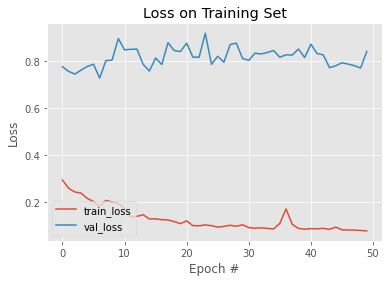

In [ ]:
# plot the model training history
N = 50
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.title("Loss on Training Set")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.show()

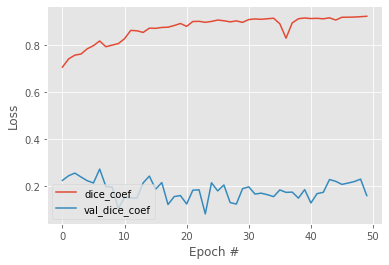

In [ ]:
N = 50
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["dice_coef"], label="dice_coef")
plt.plot(np.arange(0, N), history.history["val_dice_coef"], label="val_dice_coef")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.show()

In [ ]:
x_train.shape

(1800, 2, 240, 240)

In [ ]:
x_train[400].shape

(2, 240, 240)

In [ ]:
x_train[400][0].shape

(240, 240)

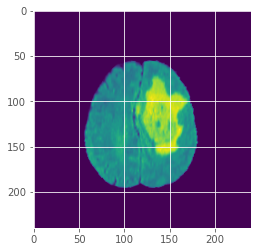

In [ ]:
plt.imshow(x_train[500][0])

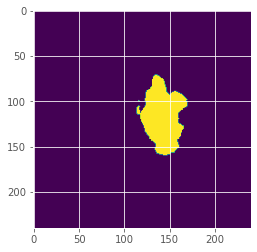

In [ ]:
plt.imshow(seg[500][0])

In [ ]:
örnek = np.expand_dims(x_train[500],axis=0)

In [ ]:
x_train[500].shape

(2, 240, 240)

In [ ]:
örnek.shape

(1, 2, 240, 240)

In [ ]:
pred = model.predict(örnek)

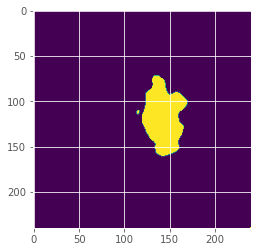

In [ ]:
plt.imshow(pred[0][0])

In [ ]:

def tahmin(x,a) :
    renk = {0:'magma',
            1:'viridis',
            2:'gray',
            3:'inferno',
            4:'cividis',
            5:'hot', }
    a    = a

    örnek = np.expand_dims(x_train[x],axis=0)
    pred = model.predict(örnek)


    fig = plt.figure(figsize=(15,10))

    plt.subplot(141)
    plt.title('Input (Flair + T2)')
    plt.imshow(x_train[x][0],cmap = renk[a])

    plt.subplot(142)
    plt.title('Radiologist (segmentation)')
    plt.imshow( seg[x][0],cmap = renk[a])

    plt.subplot(143)
    plt.title('Bilgisayarın tahmini (Prediction)')
    return plt.imshow( pred[0][0],cmap = renk[a])

# Model tahmin sonuçları

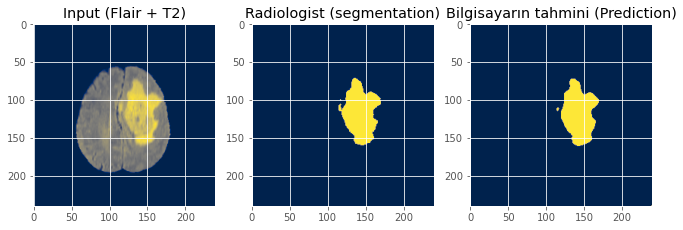

In [ ]:
tahmin(500,4)

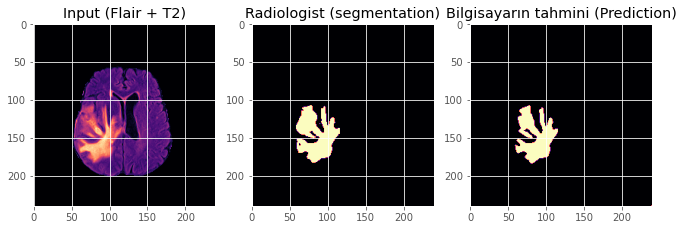

In [ ]:
tahmin(1000,0)

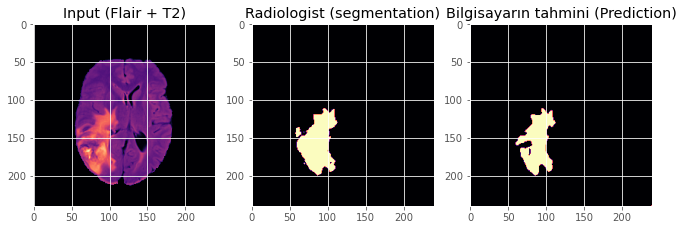

In [ ]:
tahmin(1500,0)

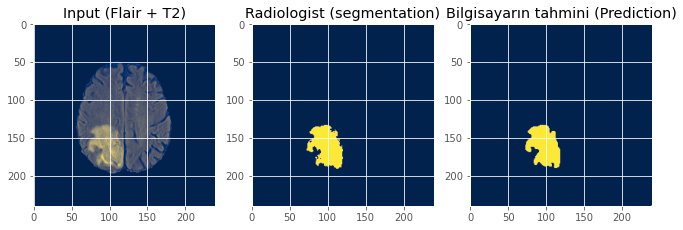

In [ ]:
tahmin(650,4)

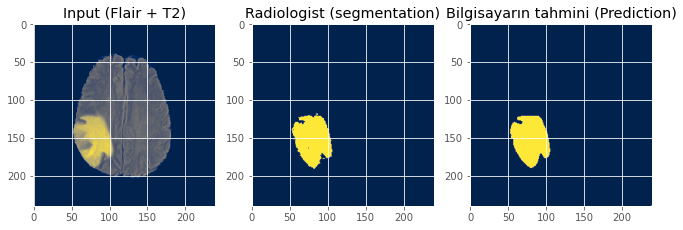

In [ ]:
tahmin(950,4)

* # **Tümörlü kısımda kırpma işlemleri**

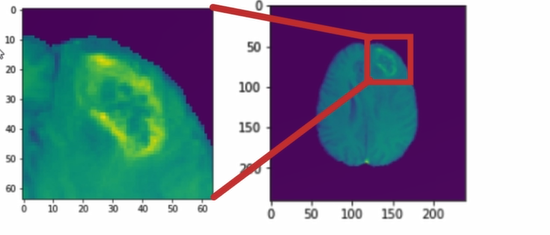

Text(0.5, 1.0, 'ham görüntü')

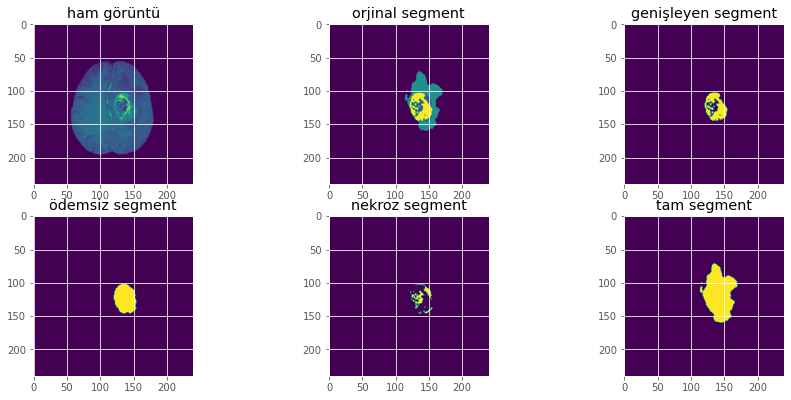

In [ ]:
x=500

plt.figure(figsize=(15,10))

plt.subplot(3,3,6)
plt.imshow(seg_tam[x].reshape(240,240))
plt.title("tam segment")

plt.subplot(3,3,5)
plt.imshow(seg_nekroz[x].reshape(240,240))
plt.title("nekroz segment")

plt.subplot(3,3,4)
plt.imshow(seg_ödemsiz[x].reshape(240,240))
plt.title("ödemsiz segment")

plt.subplot(3,3,3)
plt.imshow(seg_geniş[x].reshape(240,240))
plt.title("genişleyen segment")

plt.subplot(3,3,2)
plt.imshow(seg_orj[x].reshape(240,240))
plt.title("orjinal segment")

plt.subplot(3,3,1)
plt.imshow(train[x].reshape(240,240))
plt.title("ham görüntü")

In [ ]:
tmp = seg_ödemsiz[500,0,:,:]
tmp.shape

(240, 240)

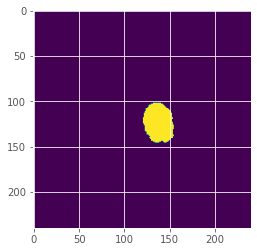

In [ ]:
plt.imshow(tmp)

In [ ]:
t1ce = train_array("..//input//brain-tumor//MICCAI_BraTS2020_TrainingData//","**//*t1ce.nii")

In [ ]:
tmp[tmp>0.2] = 1
tmp[tmp!= 1] = 0

In [ ]:
index_xy = np.where(tmp==1)

In [ ]:
index_xy

(array([102, 102, 102, ..., 145, 145, 145]),
 array([132, 133, 134, ..., 144, 145, 146]))

In [ ]:
merkez_y = (max(index_xy[0]) + (min(index_xy[0])) ) / 2
merkez_x = (max(index_xy[1]) + (min(index_xy[1])) ) / 2

In [ ]:
merkez_y,merkez_x

(123.5, 137.5)

In [ ]:
img_x =  np.zeros((64,64), np.float32)

In [ ]:
x=t1ce[500,0,:,:]
x.shape

(240, 240)

In [ ]:
img_x[:,:] = x[int(merkez_y - 64/2):int(merkez_y + 64/2),int(merkez_x - 64/2):int(merkez_x + 64/2) ]

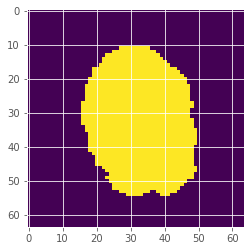

In [ ]:
plt.imshow(img_x)

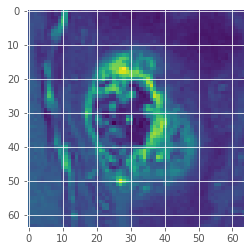

In [ ]:
plt.imshow(img_x)

In [ ]:
def tümör_kırpma(mr,seg):
    
    mr = mr[0]
    liste = []
    tmp = seg[0,:,:]
    tmp[tmp>0.2] = 1
    tmp[tmp!= 1] = 0
    index_xy = np.where(tmp==1)
    
    if index_xy[0] != []:
        merkez_y = (max(index_xy[0]) + (min(index_xy[0])) ) / 2
        merkez_x = (max(index_xy[1]) + (min(index_xy[1])) ) / 2
        img_x =  np.zeros((64,64), np.float32)
        img_x[:,:] = mr[int(merkez_y - 64/2):int(merkez_y + 64/2),int(merkez_x - 64/2):int(merkez_x + 64/2) ]
        liste.append(img_x)
        
    return np.array(liste)

In [ ]:
t1ce_def = tümör_kırpma(t1ce[500],seg_ödemsiz[500])
nekroz_def = tümör_kırpma(seg_nekroz[500],seg_ödemsiz[500])
geniş_def = tümör_kırpma(seg_geniş[500],seg_ödemsiz[500])
ödemsiz_def = tümör_kırpma(seg_ödemsiz[500],seg_ödemsiz[500])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


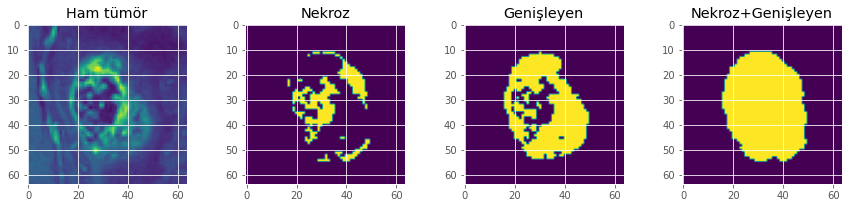

In [ ]:
plt.figure(figsize=(15,10))

plt.subplot(3,4,1)
plt.title("Ham tümör")
plt.imshow(t1ce_def[0])

plt.subplot(3,4,2)
plt.title("Nekroz")
plt.imshow(nekroz_def[0])

plt.subplot(3,4,3)
plt.title("Genişleyen")
plt.imshow(geniş_def[0])

plt.subplot(3,4,4)
plt.title("Nekroz+Genişleyen")
plt.imshow(ödemsiz_def[0])

In [ ]:
len(seg_ödemsiz)

1800

In [ ]:
liste_ =[]
for i in range(len(seg_ödemsiz)):
    img = tümör_kırpma(seg_ödemsiz[i],seg_ödemsiz[i])
    if len(img.shape) > 2: #bazen veriler boş dönüyor hata çıkmaması için 
        liste_.append(img)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
train_y=np.array(liste_)
train_y.shape

(967, 1, 64, 64)

In [ ]:
train=np.array(liste_)

In [ ]:
train.shape

(967, 1, 64, 64)

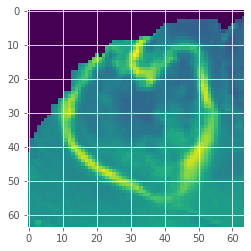

In [ ]:
plt.imshow(train[15,0,:,:])

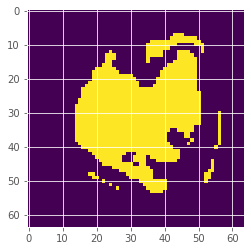

In [ ]:
plt.imshow(train_y[15,0,:,:])

In [ ]:
ödemsiz=np.array(liste_)

In [ ]:
nekroz=np.array(liste_)

In [ ]:
geniş=np.array(liste_)

In [ ]:
t1ce=np.array(liste_)

In [ ]:
t1ce.shape,ödemsiz.shape,geniş.shape,nekroz.shape

((967, 1, 64, 64), (967, 1, 64, 64), (967, 1, 64, 64), (967, 1, 64, 64))

# unet_model_7

In [ ]:

def unet_model_7():
    
    inputs = Input((1, 64, 64))
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same') (inputs)
    batch1 = BatchNormalization(axis=1)(conv1)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same') (batch1)
    batch1 = BatchNormalization(axis=1)(conv1)
    pool1 = MaxPooling2D((2, 2)) (batch1)
    
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same') (pool1)
    batch2 = BatchNormalization(axis=1)(conv2)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same') (batch2)
    batch2 = BatchNormalization(axis=1)(conv2)
    pool2 = MaxPooling2D((2, 2)) (batch2)
    
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same') (pool2)
    batch3 = BatchNormalization(axis=1)(conv3)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same') (batch3)
    batch3 = BatchNormalization(axis=1)(conv3)
    pool3 = MaxPooling2D((2, 2)) (batch3)
     
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same') (pool3)
    batch5 = BatchNormalization(axis=1)(conv5)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same') (batch5)
    batch5 = BatchNormalization(axis=1)(conv5)
    
    up7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same') (batch5)
    up7 = concatenate([up7, conv3], axis=1)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same') (up7)
    batch7 = BatchNormalization(axis=1)(conv7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same') (batch7)
    batch7 = BatchNormalization(axis=1)(conv7)
    
    up8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (batch7)
    up8 = concatenate([up8, conv2], axis=1)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same') (up8)
    batch8 = BatchNormalization(axis=1)(conv8)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same') (batch8)
    batch8 = BatchNormalization(axis=1)(conv8)
    
    up9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (batch8)
    up9 = concatenate([up9, conv1], axis=1)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same') (up9)
    batch9 = BatchNormalization(axis=1)(conv9)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same') (batch9)
    batch9 = BatchNormalization(axis=1)(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(batch9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer=Adam(lr=1e-4), loss=dice_coef_loss, metrics=[dice_coef])

    return model



In [ ]:
model_ödemsiz = unet_model_7()

# Kırpılmış görüntülerin eğitimi

In [ ]:
history = model_ödemsiz.fit(t1ce,
                        ödemsiz,
                       validation_split=0.20,
                        batch_size = 10,
                        epochs = 10,
                        shuffle = True,
                        verbose = 1
                       )

Epoch 1/10
78/78 [==============================] - 2s 28ms/step - loss: 0.3505 - dice_coef: 0.6510 - val_loss: 0.6772 - val_dice_coef: 0.3144
Epoch 2/10
78/78 [==============================] - 2s 24ms/step - loss: 0.1989 - dice_coef: 0.8017 - val_loss: 0.6907 - val_dice_coef: 0.3043
Epoch 3/10
78/78 [==============================] - 2s 24ms/step - loss: 0.1627 - dice_coef: 0.8381 - val_loss: 0.4330 - val_dice_coef: 0.5527
Epoch 4/10
78/78 [==============================] - 2s 24ms/step - loss: 0.1167 - dice_coef: 0.8821 - val_loss: 0.9598 - val_dice_coef: 0.0392
Epoch 5/10
78/78 [==============================] - 2s 24ms/step - loss: 0.1041 - dice_coef: 0.8962 - val_loss: 0.7977 - val_dice_coef: 0.1964
Epoch 6/10
78/78 [==============================] - 2s 24ms/step - loss: 0.0917 - dice_coef: 0.9076 - val_loss: 0.5158 - val_dice_coef: 0.4753
Epoch 7/10
78/78 [==============================] - 2s 24ms/step - loss: 0.0728 - dice_coef: 0.9253 - val_loss: 0.6780 - val_dice_coef: 0.3124

In [ ]:
model_geniş=unet_model_7()

In [ ]:
history = model_geniş.fit(t1ce,
                        geniş,
                        validation_split=0.20,
                        batch_size = 10,
                        epochs = 10,
                        shuffle = True,
                        verbose = 1
                       )

Epoch 1/10
78/78 [==============================] - 2s 31ms/step - loss: 0.5145 - dice_coef: 0.4852 - val_loss: 0.9055 - val_dice_coef: 0.0917
Epoch 2/10
78/78 [==============================] - 2s 24ms/step - loss: 0.3785 - dice_coef: 0.6225 - val_loss: 0.9352 - val_dice_coef: 0.0629
Epoch 3/10
78/78 [==============================] - 2s 24ms/step - loss: 0.3255 - dice_coef: 0.6698 - val_loss: 0.9091 - val_dice_coef: 0.0882
Epoch 4/10
78/78 [==============================] - 2s 25ms/step - loss: 0.2766 - dice_coef: 0.7202 - val_loss: 0.8646 - val_dice_coef: 0.1314
Epoch 5/10
78/78 [==============================] - 2s 24ms/step - loss: 0.2488 - dice_coef: 0.7505 - val_loss: 0.8262 - val_dice_coef: 0.1686
Epoch 6/10
78/78 [==============================] - 2s 24ms/step - loss: 0.2147 - dice_coef: 0.7851 - val_loss: 0.8103 - val_dice_coef: 0.1840
Epoch 7/10
78/78 [==============================] - 2s 24ms/step - loss: 0.1982 - dice_coef: 0.8014 - val_loss: 0.8018 - val_dice_coef: 0.1922

# kırpılmış görüntülerle tahmin

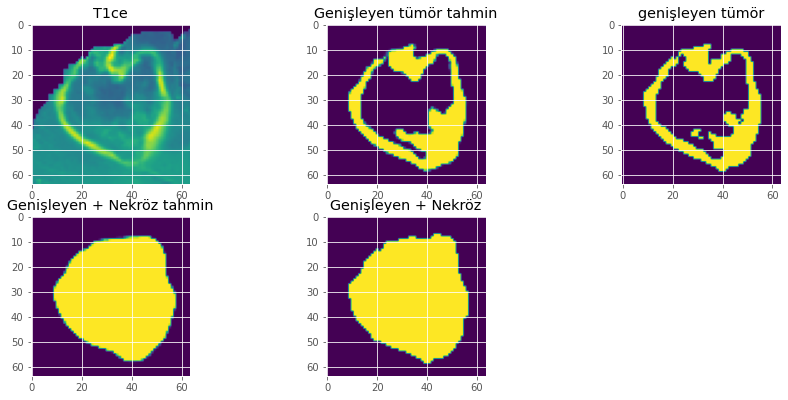

In [ ]:
x = 15

plt.figure(figsize=(15,10))

plt.subplot(3,3,1)
plt.title("T1ce")
plt.imshow(t1ce[x,0,:,:])

pred_geniş = model_geniş.predict(t1ce[x:x+1,:,:,:])
plt.subplot(3,3,2)
plt.title("Genişleyen tümör tahmin")
plt.imshow(pred_geniş[0,0,:,:])

plt.subplot(3,3,3)
plt.title("genişleyen tümör")
plt.imshow(geniş[x,0,:,:])

pred_ödemsiz = model_ödemsiz.predict(t1ce[x:x+1,:,:,:])
plt.subplot(3,3,4)
plt.title("Genişleyen + Nekröz tahmin")
plt.imshow(pred_ödemsiz[0,0,:,:])

plt.subplot(3,3,5)
plt.title("Genişleyen + Nekröz")
plt.imshow(ödemsiz[x,0,:,:])

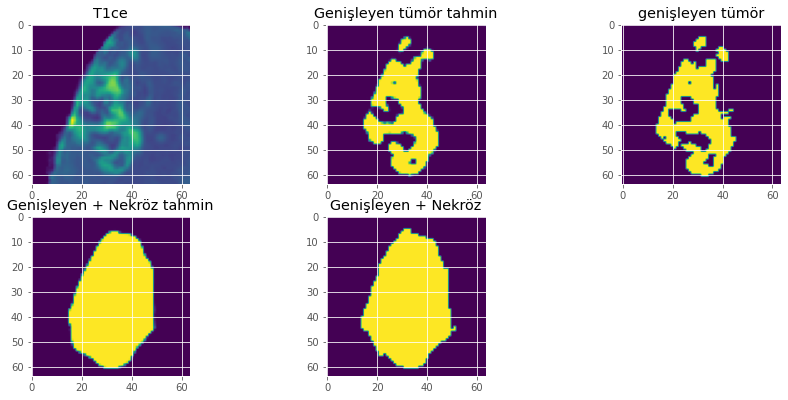

In [ ]:
x = 45

plt.figure(figsize=(15,10))

plt.subplot(3,3,1)
plt.title("T1ce")
plt.imshow(t1ce[x,0,:,:])

pred_geniş = model_geniş.predict(t1ce[x:x+1,:,:,:])
plt.subplot(3,3,2)
plt.title("Genişleyen tümör tahmin")
plt.imshow(pred_geniş[0,0,:,:])

plt.subplot(3,3,3)
plt.title("genişleyen tümör")
plt.imshow(geniş[x,0,:,:])

pred_ödemsiz = model_ödemsiz.predict(t1ce[x:x+1,:,:,:])
plt.subplot(3,3,4)
plt.title("Genişleyen + Nekröz tahmin")
plt.imshow(pred_ödemsiz[0,0,:,:])

plt.subplot(3,3,5)
plt.title("Genişleyen + Nekröz")
plt.imshow(ödemsiz[x,0,:,:])